In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import random_split, DataLoader
from config import LOGGER, ID_TO_LABEL, DATA_PATH, MODEL_PATH, SEED, TRANSFORMS, NUM_CHANNELS, LEFT_SIDE, RIGHT_SIDE, DELTA, BS, NUM_EPOCHS, DEVICE


from utils import train_step, test_step
from dataset import ImageDataset
from model import Model


In [2]:
dataset = ImageDataset(DATA_PATH, TRANSFORMS)

In [3]:
to_pil = torchvision.transforms.ToPILImage()

label: 445cc
torch.Size([4, 50, 200])


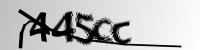

In [4]:
sample_idx = -89
sample = dataset[sample_idx]
print('label:', ''.join([ID_TO_LABEL[k.item()] for k in sample[1]]))
print(sample[0].shape)
to_pil(sample[0])

Last channel is empty:

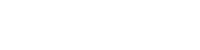

In [5]:
to_pil(sample[0][-1])

Show first channel and mean of the channels

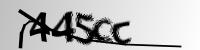

In [6]:
to_pil(sample[0][0])

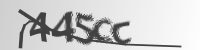

In [7]:
to_pil(sample[0].mean(axis=0))

## Define borders

There is large left and right padding, lets compute padding length:

In [8]:
test_size = len(dataset) // 5
train_size = len(dataset) - test_size

In [9]:
torch.manual_seed(SEED + 5)
dataset = ImageDataset(DATA_PATH, transforms=TRANSFORMS, channels=3)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print('train size:', train_size)
print('test_size:', test_size)

train size: 856
test_size: 214


In [10]:
BS = 32
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=0)

In [11]:
from matplotlib import pyplot as plt

In [12]:
def build_mean_image(loader):
    data = []
    for img, _ in iter(loader):
        data.append(img.mean(axis=(0,1)).numpy())
    data = np.array(data).mean(axis=0)
    return data

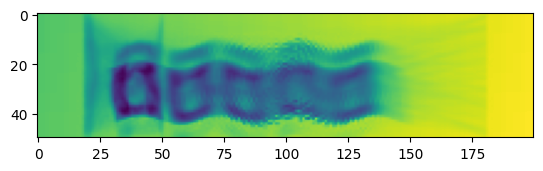

In [13]:
plt.imshow(build_mean_image(train_loader))

In [14]:
LEFT_SIDE = 20
RIGHT_SIDE = 150
DELTA = 2

Lets check this assumption on test data:

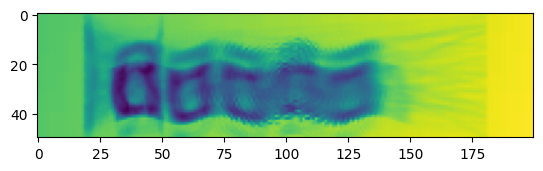

In [15]:
plt.imshow(build_mean_image(test_loader))

Image after reducing padding

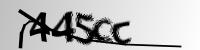

In [16]:
to_pil(dataset[sample_idx][0])

## Model (create and training)

## Errors

Suppose our model is trained (you need to run training script, go to README.md in the repo)

In [17]:
model = Model(in_channels=NUM_CHANNELS)

In [18]:
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1)

In [19]:
dataset = ImageDataset(DATA_PATH,
                       transforms=TRANSFORMS,
                       channels=NUM_CHANNELS,
                       left_side=(LEFT_SIDE - DELTA),
                       right_side=(RIGHT_SIDE + DELTA))

In [20]:
dataloader = DataLoader(dataset, shuffle=False, batch_size=BS, num_workers=1)

Go through all data to find samples with wrong prediction:

In [21]:
model.eval()
preds_list = []
labels_list = []
with torch.no_grad():
    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        out = model(X)
        
        _, preds = torch.max(out, dim=1)
        
        labels_list.extend(y.numpy())
        preds_list.extend(preds.numpy())

preds = np.array(preds_list)
labels = np.array(labels_list)

In [24]:
bads = []

for sample_idx, (tr, err) in enumerate(zip(labels, preds)):
    if np.any(tr != err):
        label = ''.join([ID_TO_LABEL[i] for i in tr])
        pred = ''.join([ID_TO_LABEL[i] for i in err])
        print(f'id: {sample_idx}, label/pred: {label}/{pred}')
        bads.append(sample_idx)
print('Wrong labels recognized:',len(bads))

id: 20, label/pred: m22e3/m22e8
id: 70, label/pred: wce5n/wce6m
id: 93, label/pred: edg3p/cdg3p
id: 110, label/pred: 4w6mw/4w6nm
id: 127, label/pred: pmd3w/pmd7w
id: 167, label/pred: 3ye2e/3ge2e
id: 228, label/pred: mc8w2/mc44w
id: 237, label/pred: nwncn/nwncm
id: 308, label/pred: mmg2m/mmg2n
id: 322, label/pred: xc68n/xc64n
id: 359, label/pred: my84e/my44e
id: 376, label/pred: f2fge/f2fee
id: 413, label/pred: c3572/c377x
id: 501, label/pred: 8w754/8w774
id: 602, label/pred: mfb3x/mfb6x
id: 656, label/pred: wgnwp/wgmwp
id: 662, label/pred: m4g8g/m4gg4
id: 776, label/pred: wm746/wmm46
id: 906, label/pred: 4w76g/4w75g
id: 996, label/pred: cnwyc/cnwyg
Wrong labels recognized: 20


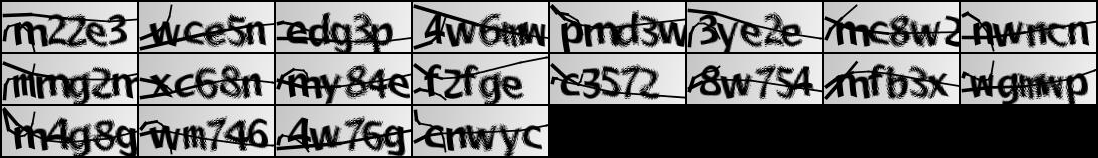

In [23]:
bads_tensors = [dataset[i][0] for i in range(len(dataset)) if i in bads]
to_pil(torchvision.utils.make_grid(bads_tensors))

It depends....

- Some images were recognized wrong due to small pading (fix: extend padding while performing transforms)
- Some images have difficult-recognizable characters (fix: try to make model more comlex)
- Somewhere error should not apper (fix: try to train extra epochs)